### Connect to Neo4j and Verify Connection

In [1]:
from py2neo import Graph

# Connect to Neo4j using bolt://localhost:7687
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password"))

# Test the connection by running a basic query
result = graph.run("MATCH (n) RETURN COUNT(n)").data()
print(result)

[{'COUNT(n)': 56849}]


### Poster 3 query graph

In [ ]:
import pandas as pd

df_results = pd.read_csv("../data/cache/test_movies_query.csv")
# Extract tconst values from the df_results DataFrame (assuming the column name is 'tconst')
tconst_values = df_results["tconst"].tolist()

directors = []
actors = []
production_cos = []

# Iterate over each tconst and run the query
for tconst in tconst_values:
    # Prepare the dynamic list of tconsts for the query
    tconst_query_list = [tconst]

    # Construct the Cypher query for production companies
    cypher_query = f"""
    MATCH (m:Movie)-[:PRODUCED_BY]->(pc:ProductionCompany)
    WHERE m.tconst IN {tconst_query_list}
    WITH pc.name AS studio, count(*) AS count
    ORDER BY count DESC
    LIMIT 1
    RETURN studio
    """

    # Execute the query and process the result
    result = graph.run(cypher_query)

    # Extract and append the cleaned production company name
    for record in result:
        production_cos.append(record['studio'].strip())  # Strip spaces and append the cleaned production company name

    # Construct the Cypher query for directors
    cypher_query2 = f"""
    MATCH (d:Director)-[:DIRECTED]->(m:Movie)
    WHERE m.tconst IN {tconst_query_list}
    WITH d.name AS director, count(*) AS count
    ORDER BY count DESC
    LIMIT 1
    RETURN director
    """

    # Execute the query and process the result
    result = graph.run(cypher_query2)

    # Extract and append the cleaned director name
    for record in result:
        directors.append(record['director'].strip()) 

    # Construct the Cypher query for top 2 actors
    cypher_query3 = f"""
    MATCH (a:Actor)-[:ACTED_IN]->(m:Movie)
    WHERE m.tconst IN {tconst_query_list}
    WITH a.name AS actor, count(*) AS appearances
    ORDER BY appearances DESC
    LIMIT 2
    RETURN actor
    """

    # Execute the query and process the result
    result = graph.run(cypher_query3)
    # Append the actors for this movie to the local list (clearing it at each iteration)
    actors_for_current_movie = []
    for record in result:
        actors_for_current_movie.append(record['actor'].strip())

    # Append actors list of the current movie to the main actors list
    actors.append(actors_for_current_movie)

# Print the results for directors, production companies, and actors
for record in zip(directors, production_cos, actors):
    print(f"Director: {record[0]}, Production Company: {record[1]}, Actor: {record[2]}")


### Create Budget-Tiered Subgraphs in Neo4j Using Cypher Projection

In [2]:
# train data only

from py2neo import Graph
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password"))

# People included
for tier in ["low", "medium", "high", "tentpole"]:
    graph.run(f"""
        CALL gds.graph.exists('subgraph_train_{tier}') YIELD exists
        WITH exists WHERE exists
        CALL gds.graph.drop('subgraph_train_{tier}', false) YIELD graphName
        RETURN graphName
    """)

    graph.run(f"""
        CALL gds.graph.project.cypher(
            'subgraph_train_{tier}',
            '
                MATCH (n)
                WHERE (n:Movie AND n.budgetCategory = "{tier}" AND n.label = "train")
                      OR (NOT n:Movie)
                RETURN id(n) AS id
            ',
            '
                MATCH (m:Movie)-[r]-(x)
                WHERE m.budgetCategory = "{tier}" AND m.label = "train"
                RETURN id(m) AS source, id(x) AS target, type(r) AS type
            ',
            {{validateRelationships: false}}
        )
    """)

# No people
for tier in ["low", "medium", "high", "tentpole"]:
    graph.run(f"""
        CALL gds.graph.exists('subgraph_noppl_train_{tier}') YIELD exists
        WITH exists WHERE exists
        CALL gds.graph.drop('subgraph_noppl_train_{tier}', false) YIELD graphName
        RETURN graphName
    """)

    graph.run(f"""
        CALL gds.graph.project.cypher(
            'subgraph_noppl_train_{tier}',
            '
                MATCH (n)
                WHERE (n:Movie AND n.budgetCategory = "{tier}" AND n.label = "train")
                      OR (n:Genre OR n:Subgenre OR n:Company)
                RETURN id(n) AS id
            ',
            '
                MATCH (m:Movie)-[r]-(x)
                WHERE m.budgetCategory = "{tier}" AND m.label = "train"
                  AND (x:Genre OR x:Subgenre OR x:Company OR x:Movie)
                RETURN id(m) AS source, id(x) AS target, type(r) AS type
            ',
            {{validateRelationships: false}}
        )
    """)

print("✅ Train-only graphs (with and without people) created.")

✅ Train-only graphs (with and without people) created.


In [3]:
# full dataset

# People included
for tier in ["low", "medium", "high", "tentpole"]:
    graph.run(f"""
        CALL gds.graph.exists('subgraph_full_{tier}') YIELD exists
        WITH exists WHERE exists
        CALL gds.graph.drop('subgraph_full_{tier}', false) YIELD graphName
        RETURN graphName
    """)

    graph.run(f"""
        CALL gds.graph.project.cypher(
            'subgraph_full_{tier}',
            '
                MATCH (n)
                WHERE (n:Movie AND n.budgetCategory = "{tier}")
                      OR (NOT n:Movie)
                RETURN id(n) AS id
            ',
            '
                MATCH (m:Movie)-[r]-(x)
                WHERE m.budgetCategory = "{tier}"
                RETURN id(m) AS source, id(x) AS target, type(r) AS type
            ',
            {{validateRelationships: false}}
        )
    """)

# No people
for tier in ["low", "medium", "high", "tentpole"]:
    graph.run(f"""
        CALL gds.graph.exists('subgraph_noppl_full_{tier}') YIELD exists
        WITH exists WHERE exists
        CALL gds.graph.drop('subgraph_noppl_full_{tier}', false) YIELD graphName
        RETURN graphName
    """)

    graph.run(f"""
        CALL gds.graph.project.cypher(
            'subgraph_noppl_full_{tier}',
            '
                MATCH (n)
                WHERE (n:Movie AND n.budgetCategory = "{tier}")
                      OR (n:Genre OR n:Subgenre OR n:Company)
                RETURN id(n) AS id
            ',
            '
                MATCH (m:Movie)-[r]-(x)
                WHERE m.budgetCategory = "{tier}" 
                  AND (x:Genre OR x:Subgenre OR x:Company OR x:Movie)
                RETURN id(m) AS source, id(x) AS target, type(r) AS type
            ',
            {{validateRelationships: false}}
        )
    """)

print("✅ Full dataset graphs (with and without people) created.")

✅ Full dataset graphs (with and without people) created.


### Run Louvain Community Detection for Each Budget Tier

In [4]:
all_louvain_results = []

for mode in ["train", "full", "noppl_train", "noppl_full"]:
    for tier in ["low", "medium", "high", "tentpole"]:
        subgraph_name = f"subgraph_{mode}_{tier}"

        df = graph.run(f"""
            CALL gds.louvain.stream('{subgraph_name}')
            YIELD nodeId, communityId
            WITH gds.util.asNode(nodeId) AS n, communityId
            WHERE n:Movie
            RETURN n.primaryTitle AS movie, communityId
            ORDER BY communityId ASC
        """).to_data_frame()

        df["graph_type"] = mode
        df["budget_tier"] = tier
        all_louvain_results.append(df)

# Combine all into one big DataFrame
df_louvain_all = pd.concat(all_louvain_results, ignore_index=True)


NameError: name 'pd' is not defined

### Count Nodes per Louvain Community for Each Budget Tier

In [ ]:
for mode in ["train", "full", "noppl_train", "noppl_full"]:
    for tier in ["low", "medium", "high", "tentpole"]:
        subgraph_name = f"subgraph_{mode}_{tier}"

        df = graph.run(f"""
            CALL gds.louvain.stream('{subgraph_name}')
            YIELD nodeId, communityId
            WITH gds.util.asNode(nodeId) AS n, communityId
            WHERE n:Movie
            RETURN communityId, COUNT(*) AS numMovies
            ORDER BY numMovies DESC
        """).to_data_frame()

        print(f"\n--- {mode.upper()} | {tier.upper()} Budget: Movies per Community ---")
        print(df)

### Load and Combine Training + Validation Sets (Excluding Indie Tier)

In [5]:
import pandas as pd

df_train = pd.read_csv("../data/cache/poster3_train_graphed.csv")
df_test = pd.read_csv("../data/cache/poster3_test.csv")

# Drop 'indie' from both
df_train = df_train[df_train["from_budget_category"] != "indie"].reset_index(drop=True)
df_test = df_test[df_test["from_budget_category"] != "indie"].reset_index(drop=True)

### One-Hot Encode Genres and Subgenres for Test Set

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

def split_tags(col):
    return col.fillna("").apply(lambda x: [t.strip() for t in x.split(",") if t.strip()])

# Fit on train set
mlb_genre = MultiLabelBinarizer()
mlb_genre.fit(split_tags(df_train["genres"]))

mlb_subgenre = MultiLabelBinarizer()
mlb_subgenre.fit(split_tags(df_train["subgenres"]))

# Transform test set
genre_onehot = pd.DataFrame(
    mlb_genre.transform(split_tags(df_test["genres"])),
    columns=[f"genre_{g}" for g in mlb_genre.classes_]
)
subgenre_onehot = pd.DataFrame(
    mlb_subgenre.transform(split_tags(df_test["subgenres"])),
    columns=[f"subgenre_{s}" for s in mlb_subgenre.classes_]
)

# Merge into df_test
df_test_final = pd.concat([df_test.reset_index(drop=True), genre_onehot, subgenre_onehot], axis=1)

# Transform train set using the same encoders
genre_onehot_train = pd.DataFrame(
    mlb_genre.transform(split_tags(df_train["genres"])),
    columns=[f"genre_{g}" for g in mlb_genre.classes_]
)
subgenre_onehot_train = pd.DataFrame(
    mlb_subgenre.transform(split_tags(df_train["subgenres"])),
    columns=[f"subgenre_{s}" for s in mlb_subgenre.classes_]
)

df_train = pd.concat([df_train.reset_index(drop=True), genre_onehot_train, subgenre_onehot_train], axis=1)

### Merge Louvain Communities with Movie Genre/Subgenre Features

COSINE PROJECTION (df_test_multi)

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

all_rows = []

for graph_type in ["train", "noppl_train"]:
    print(f"\n===== Running projections for: {graph_type.upper()} =====\n")

    for tier in ["low", "medium", "high", "tentpole"]:
        print(f"Processing tier: {tier}")

        # Step 1: Pull Louvain community assignments from Neo4j
        movies_tier_df = graph.run(f"""
            CALL gds.louvain.stream('subgraph_{graph_type}_{tier}')
            YIELD nodeId, communityId
            WITH gds.util.asNode(nodeId) AS n, communityId
            WHERE n:Movie
            RETURN n.primaryTitle AS from_title, communityId
        """).to_data_frame()

        movies_tier_df["budget_tier"] = tier

        # Step 2: Merge with training features
        merged = movies_tier_df.merge(df_train, on="from_title", how="inner")
        feature_cols = [c for c in merged.columns if c.startswith("genre_") or c.startswith("subgenre_")]

        # Step 3: Filter communities (≥ 8 movies)
        community_counts = merged.groupby("communityId").size()
        valid_comms = community_counts[community_counts >= 8].index
        merged_filtered = merged[merged["communityId"].isin(valid_comms)].copy()

        print(f"[{tier}] Merged movie-community shape: {merged.shape}")
        print(f"[{tier}] Valid communities (≥8 movies): {len(valid_comms)}")
        print(f"[{tier}] Filtered set shape: {merged_filtered.shape}")

        if merged_filtered.empty:
            continue

        # Step 4: Compute feature centroids
        community_centroids = merged_filtered.groupby("communityId")[feature_cols].mean().replace(np.nan, 0)
        test_feature_cols = [c for c in df_test_final.columns if c.startswith("genre_") or c.startswith("subgenre_")]
        available_cols = [col for col in test_feature_cols if col in community_centroids.columns]
        print(f"[{tier}] Using {len(available_cols)} feature columns for similarity")

        X_centroids = community_centroids[available_cols].values
        filtered_test = df_test_final[df_test_final["from_budget_category"] == tier]
        print(f"[{tier}] Test movies to project: {len(filtered_test)}")

        for _, row_test in filtered_test.iterrows():
            test_vec = row_test[available_cols].replace(np.nan, 0).values.reshape(1, -1)
            if X_centroids.size == 0:
                continue

            sims = cosine_similarity(test_vec, X_centroids)[0]
            best_id = community_centroids.index[sims.argmax()]

            out_row = {
                "from_title": row_test["from_title"],
                "budget_tier": tier,
                "matched_community_id": best_id,
                "profit_median": merged_filtered.loc[merged_filtered["communityId"] == best_id, "profit"].median(),
                "roi_median": merged_filtered.loc[merged_filtered["communityId"] == best_id, "profit_percent_gain"].median(),
                "profit": row_test.get("profit", np.nan),
                "roi": row_test.get("profit_percent_gain", np.nan),
                "graph_type": graph_type
            }

            print(f"Projected {row_test['from_title']} → community {best_id} (tier: {tier})")
            all_rows.append(out_row)

# Combine both train and noppl_train projections
df_test_multi = pd.DataFrame(all_rows)
print("\ndf_test_multi shape:", df_test_multi.shape)
print(df_test_multi.head(10))



===== Running projections for: TRAIN =====

Processing tier: low
[low] Merged movie-community shape: (1013, 183)
[low] Valid communities (≥8 movies): 14
[low] Filtered set shape: (616, 183)
[low] Using 152 feature columns for similarity
[low] Test movies to project: 37
Projected The Squid and the Whale → community 13321 (tier: low)
Projected The Diary of a Teenage Girl → community 13321 (tier: low)
Projected He Knows You're Alone → community 48815 (tier: low)
Projected Elvis & Nixon → community 13321 (tier: low)
Projected Love Lies Bleeding → community 48748 (tier: low)
Projected Slums of Beverly Hills → community 18309 (tier: low)
Projected I Hope They Serve Beer in Hell → community 18309 (tier: low)
Projected The Art of Self-Defense → community 18309 (tier: low)
Projected The Green Knight → community 48581 (tier: low)
Projected Love Stinks → community 18309 (tier: low)
Projected The Draughtsman's Contract → community 13321 (tier: low)
Projected Nomadland → community 49901 (tier: low

### Match Test Movies to Non-Singleton Louvain Communities via Cosine Similarity

In [ ]:
df_test_final["from_budget_category"].value_counts()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

#############################################
# 1) BUILD MOVIES_DF (the merged subgraph data)
#############################################

# We'll assume you have df_all_features = pd.concat([df_train, df_test_final], ignore_index=True)
# Make sure df_all_features is defined above this code!

df_all_features = df_train.copy()

all_movies = []
for mode in ["train", "full", "noppl_train", "noppl_full"]:
    for tier in ["low", "medium", "high", "tentpole"]:
        subgraph_name = f"subgraph_{mode}_{tier}"

        print(f"Pulling Louvain data for: {subgraph_name}")
        movies_tier_df = graph.run(f"""
            CALL gds.louvain.stream('{subgraph_name}')
            YIELD nodeId, communityId
            WITH gds.util.asNode(nodeId) AS n, communityId
            WHERE n:Movie
            RETURN n.primaryTitle AS movie, communityId
        """).to_data_frame()

        print(movies_tier_df.head())

    # Tag with tier
    movies_tier_df["budget_tier"] = tier

    # Merge subgraph results with df_all_features
    merged = movies_tier_df.merge(
        df_all_features,
        left_on="movie",
        right_on="from_title", 
        how="inner"
    )
    all_movies.append(merged)

# Combine to get the final DataFrame with subgraph data + features
movies_df = pd.concat(all_movies, ignore_index=True)

print("movies_df shape:", movies_df.shape)
print(movies_df.head(3))

#############################################
# 2) MATCH EACH TEST MOVIE TO EACH TIER
#############################################

# Identify columns with one-hot features in df_test_final and movies_df
test_feature_cols = sorted([c for c in df_test_final.columns if c.startswith("genre_") or c.startswith("subgenre_")])
graph_feature_cols = sorted([c for c in movies_df.columns if c.startswith("genre_") or c.startswith("subgenre_")])

matched_ids = []

for tier in ["low", "medium", "high", "tentpole"]:
    print(f"\nProcessing tier: {tier}")

    # Filter subgraph data for this tier
    movies_tier = movies_df[movies_df["budget_tier"] == tier].copy()

    # Optionally filter out singleton communities (> 20 means 21+ members)
    community_counts = movies_tier.groupby("communityId").size()
    valid_communities = community_counts[community_counts > 20].index
    movies_filtered = movies_tier[movies_tier["communityId"].isin(valid_communities)]

    if movies_filtered.empty:
        print(f"No valid communities for tier: {tier}. Skipping.")
        continue

    # Compute centroids
    community_centroids = (
        movies_filtered
        .groupby("communityId")[graph_feature_cols]
        .mean()
        .replace(np.nan, 0)
    )

    # Match entire test set to this tier’s centroids
    test_tier = df_test_final.copy()
    X_test = np.nan_to_num(test_tier[test_feature_cols].values)
    X_centroids = community_centroids.values

    if X_centroids.size == 0:
        print(f"No centroids computed for tier: {tier}. Skipping.")
        continue

    similarity_matrix = cosine_similarity(X_test, X_centroids)
    best_idxs = similarity_matrix.argmax(axis=1)
    best_ids = community_centroids.index[best_idxs]

    matched = test_tier.copy()
    matched["budget_tier"] = tier
    matched["matched_community_id"] = best_ids.values

    matched_ids.append(matched)

df_test_final = pd.concat(matched_ids, ignore_index=True)
print("\nFinal df_test_final shape:", df_test_final.shape)
print(df_test_final.head(8))


### GROUND TRUTH CLUSTER ASSIGNMENT (df_truth)

In [16]:
import pandas as pd

truth_rows = []

for mode in ["full", "noppl_full"]:
    for tier in ["low", "medium", "high", "tentpole"]:
        subgraph_name = f"subgraph_{mode}_{tier}"
        print(f"Pulling ground truth for: {subgraph_name}")

        df = graph.run(f"""
            CALL gds.louvain.stream('{subgraph_name}')
            YIELD nodeId, communityId
            WITH gds.util.asNode(nodeId) AS n, communityId
            WHERE n:Movie AND n.label = "test"
            RETURN n.primaryTitle AS from_title, communityId
        """).to_data_frame()

        df["budget_tier"] = tier
        df["graph_type"] = mode
        df.rename(columns={"communityId": "true_community_id"}, inplace=True)
        truth_rows.append(df)

df_truth = pd.concat(truth_rows, ignore_index=True)
print("df_truth shape:", df_truth.shape)
print(df_truth.head())

Pulling ground truth for: subgraph_full_low
Pulling ground truth for: subgraph_full_medium
Pulling ground truth for: subgraph_full_high
Pulling ground truth for: subgraph_full_tentpole
Pulling ground truth for: subgraph_noppl_full_low
Pulling ground truth for: subgraph_noppl_full_medium
Pulling ground truth for: subgraph_noppl_full_high
Pulling ground truth for: subgraph_noppl_full_tentpole
df_truth shape: (462, 4)
              from_title  true_community_id budget_tier graph_type
0          Riding Giants              19575         low       full
1        Spring Breakers              46264         low       full
2       Arthur Christmas              13492         low       full
3    The Florida Project              13833         low       full
4  The Edge of Seventeen              14688         low       full


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

all_rows = []

# Define which graph you're projecting from
graph_type = "train"  # or "noppl_train"

# 1. For each tier, get community centroids from the Louvain subgraph
for tier in ["low", "medium", "high", "tentpole"]:
    print(f"Processing tier: {tier}")

    # Pull movie-community pairs from the selected train-only subgraph
    movies_tier_df = graph.run(f"""
        CALL gds.louvain.stream('subgraph_{graph_type}_{tier}')
        YIELD nodeId, communityId
        WITH gds.util.asNode(nodeId) AS n, communityId
        WHERE n:Movie
        RETURN n.primaryTitle AS from_title, communityId
    """).to_data_frame()

    movies_tier_df["budget_tier"] = tier
    merged = movies_tier_df.merge(df_train, on="from_title", how="inner")

    # Get genre/subgenre feature columns
    feature_cols = [c for c in merged.columns if c.startswith("genre_") or c.startswith("subgenre_")]

    # Filter to valid communities (≥ 8 movies)
    community_counts = merged.groupby("communityId").size()
    valid_comms = community_counts[community_counts >= 8].index
    merged_filtered = merged[merged["communityId"].isin(valid_comms)].copy()

    if merged_filtered.empty:
        print(f"No valid communities found for {tier}, skipping.")
        continue

    # Compute feature centroid for each community
    community_centroids = merged_filtered.groupby("communityId")[feature_cols].mean().replace(np.nan, 0)

    test_feature_cols = [c for c in df_test_final.columns if c.startswith("genre_") or c.startswith("subgenre_")]
    X_centroids = community_centroids[test_feature_cols].values

    for _, row_test in df_test_final.iterrows():
        test_vec = row_test[test_feature_cols].replace(np.nan, 0).values.reshape(1, -1)
        if X_centroids.size == 0:
            continue

        sims = cosine_similarity(test_vec, X_centroids)[0]
        best_id = community_centroids.index[sims.argmax()]

        all_rows.append({
            "from_title": row_test["from_title"],
            "budget_tier": tier,
            "matched_community_id": best_id,
            "graph_type": graph_type
        })

# Final DataFrame of projected community matches
df_test_multi = pd.DataFrame(all_rows)
print("df_test_multi shape:", df_test_multi.shape)
print(df_test_multi.head())

In [22]:
def compute_projection_accuracy(df_test_multi, df_truth):
    """
    Compare projected community IDs to ground truth from full Louvain runs.
    """
    # Remap graph_type in the truth data to match df_test_multi
    df_truth_mapped = df_truth.copy()
    df_truth_mapped["graph_type"] = df_truth_mapped["graph_type"].replace({
        "full": "train",
        "noppl_full": "noppl_train"
    })

    # Merge test projections with mapped ground truth
    merged = df_test_multi.merge(
        df_truth_mapped,
        on=["from_title", "budget_tier", "graph_type"],
        how="left"
    )

    # Determine match between projected and true communities
    merged["Match"] = merged["matched_community_id"] == merged["true_community_id"]

    # Type I error: assigned to wrong community
    merged["Type_I_Error"] = (
        merged["matched_community_id"].notna() &
        merged["true_community_id"].notna() &
        ~merged["Match"]
    )

    # Type II error: failed to assign any community
    merged["Type_II_Error"] = (
        merged["matched_community_id"].isna() &
        merged["true_community_id"].notna()
    )

    return merged



df_accuracy = compute_projection_accuracy(df_test_multi, df_truth)

summary = df_accuracy.groupby(["graph_type", "budget_tier"]).agg(
    accuracy=("Match", "mean"),
    type_I=("Type_I_Error", "sum"),
    type_II=("Type_II_Error", "sum"),
    total=("from_title", "count")
).reset_index()

print(summary)

    graph_type budget_tier  accuracy  type_I  type_II  total
0  noppl_train        high       0.0      58        0     58
1  noppl_train         low       0.0      37        0     37
2  noppl_train      medium       0.0      54        0     54
3  noppl_train    tentpole       0.0      82        0     82
4        train        high       0.0      58        0     58
5        train         low       0.0      37        0     37
6        train      medium       0.0      54        0     54
7        train    tentpole       0.0      82        0     82


In [24]:
# DEBUG

# Re-map graph_type from full → train for matching
df_truth_mapped = df_truth.copy()
df_truth_mapped["graph_type"] = df_truth_mapped["graph_type"].replace({
    "full": "train",
    "noppl_full": "noppl_train"
})

# Merge to diagnose which rows are failing
merged_check = df_test_multi.merge(
    df_truth_mapped,
    on=["from_title", "budget_tier", "graph_type"],
    how="left",
    indicator=True
)

# Look at merge failures
unmatched = merged_check[merged_check["_merge"] == "left_only"]
print(f"❌ Unmatched projections: {len(unmatched)} / {len(df_test_multi)}")
print(unmatched[["from_title", "budget_tier", "graph_type"]].head(20))


merged_check = df_test_multi.merge(
    df_truth_mapped,
    on=["from_title", "budget_tier", "graph_type"],
    how="left",
    indicator=True
)

# Look at rows that failed to merge
unmatched = merged_check[merged_check["_merge"] == "left_only"]
print(f"Unmatched projections: {len(unmatched)}")
print(unmatched[["from_title", "budget_tier", "graph_type"]].head(20))


❌ Unmatched projections: 0 / 462
Empty DataFrame
Columns: [from_title, budget_tier, graph_type]
Index: []
Unmatched projections: 0
Empty DataFrame
Columns: [from_title, budget_tier, graph_type]
Index: []


In [10]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

all_rows = []
graph_type = "noppl_train"

for tier in ["low", "medium", "high", "tentpole"]:
    print(f"Processing tier: {tier}")

    movies_tier_df = graph.run(f"""
        CALL gds.louvain.stream('subgraph_{graph_type}_{tier}')
        YIELD nodeId, communityId
        WITH gds.util.asNode(nodeId) AS n, communityId
        WHERE n:Movie
        RETURN n.primaryTitle AS from_title, communityId
    """).to_data_frame()

    movies_tier_df["budget_tier"] = tier
    merged = movies_tier_df.merge(df_train, on="from_title", how="inner")

    feature_cols = [c for c in merged.columns if c.startswith("genre_") or c.startswith("subgenre_")]
    community_counts = merged.groupby("communityId").size()
    valid_comms = community_counts[community_counts >= 8].index
    merged_filtered = merged[merged["communityId"].isin(valid_comms)].copy()

    if merged_filtered.empty:
        print(f"No valid communities found for {tier}, skipping.")
        continue

    community_centroids = merged_filtered.groupby("communityId")[feature_cols].mean().replace(np.nan, 0)
    available_cols = [col for col in feature_cols if col in community_centroids.columns]
    X_centroids = community_centroids[available_cols].values

    for _, row_test in df_test_final[df_test_final["from_budget_category"] == tier].iterrows():
        test_vec = row_test[available_cols].replace(np.nan, 0).values.reshape(1, -1)
        if X_centroids.size == 0:
            continue

        sims = cosine_similarity(test_vec, X_centroids)[0]
        best_id = community_centroids.index[sims.argmax()]

        all_rows.append({
            "from_title": row_test["from_title"],
            "budget_tier": tier,
            "matched_community_id": best_id,
            "graph_type": graph_type
        })

# Create df_test_multi for noppl_train
df_test_multi = pd.DataFrame(all_rows)

# Recompute accuracy using the existing function
df_accuracy_noppl = compute_projection_accuracy(df_test_multi, df_truth)

# Combine with prior train results (if you saved them)
df_accuracy_all = pd.concat([df_accuracy, df_accuracy_noppl], ignore_index=True)

# Summarize
summary = df_accuracy_all.groupby(["graph_type", "budget_tier"]).agg(
    accuracy=("Match", "mean"),
    type_I=("Type_I_Error", "sum"),
    type_II=("Type_II_Error", "sum"),
    total=("from_title", "count")
).reset_index()

print(summary)

Processing tier: low
Processing tier: medium
Processing tier: high
Processing tier: tentpole
    graph_type budget_tier  accuracy  type_I  type_II  total
0  noppl_train        high       0.0      58        0     58
1  noppl_train         low       0.0      37        0     37
2  noppl_train      medium       0.0      54        0     54
3  noppl_train    tentpole       0.0      82        0     82
4        train        high       0.0      58        0     58
5        train         low       0.0      37        0     37
6        train      medium       0.0      54        0     54
7        train    tentpole       0.0      82        0     82


In [26]:
import pandas as pd

# 1. Build movies_df with Louvain assignments from all graphs
all_movies = []

# Use df_train for merging (projections are made into train graph space)
df_all_features = df_train.copy()

for mode in ["train", "full", "noppl_train", "noppl_full"]:
    for tier in ["low", "medium", "high", "tentpole"]:
        subgraph_name = f"subgraph_{mode}_{tier}"
        print(f"Pulling Louvain data for: {subgraph_name}")

        df = graph.run(f"""
            CALL gds.louvain.stream('{subgraph_name}')
            YIELD nodeId, communityId
            WITH gds.util.asNode(nodeId) AS n, communityId
            WHERE n:Movie
            RETURN n.primaryTitle AS from_title, communityId
        """).to_data_frame()

        df["budget_tier"] = tier
        df["graph_type"] = mode
        merged = df.merge(df_all_features, on="from_title", how="inner")
        all_movies.append(merged)

# Final DataFrame
movies_df = pd.concat(all_movies, ignore_index=True)
print("movies_df shape:", movies_df.shape)
print(movies_df.head(3))


# 2. Define neighborhood overlap checker
def check_neighborhood_overlap(movie_title, tier="tentpole", truth_graph="noppl_full", proj_graph="noppl_train"):
    """
    Compare the set of training movies in the true and projected community for a given test movie.
    Looks at overlap between community memberships in truth vs. projection.
    """
    # Get true community ID from full graph
    true_row = df_truth[
        (df_truth["from_title"] == movie_title) &
        (df_truth["budget_tier"] == tier) &
        (df_truth["graph_type"] == truth_graph)
    ]

    # Get projected community ID from train-only graph
    projected_row = df_test_multi[
        (df_test_multi["from_title"] == movie_title) &
        (df_test_multi["budget_tier"] == tier) &
        (df_test_multi["graph_type"] == proj_graph)
    ]

    if true_row.empty or projected_row.empty:
        print(f"❌ Movie not found in both truth and projection: {movie_title}")
        return None

    true_comm = true_row["true_community_id"].values[0]
    proj_comm = projected_row["matched_community_id"].values[0]

    # Get members of the true and projected communities (TRAINING movies only)
    true_members = movies_df[
        (movies_df["budget_tier"] == tier) &
        (movies_df["graph_type"] == truth_graph) &
        (movies_df["communityId"] == true_comm)
    ]["from_title"]

    projected_members = movies_df[
        (movies_df["budget_tier"] == tier) &
        (movies_df["graph_type"] == proj_graph) &
        (movies_df["communityId"] == proj_comm)
    ]["from_title"]

    set_true = set(true_members)
    set_proj = set(projected_members)

    intersection = set_true & set_proj
    union = set_true | set_proj

    jaccard = len(intersection) / len(union) if union else 0

    print(f"🎬 {movie_title}")
    print(f"→ True cluster size: {len(set_true)} | Projected cluster size: {len(set_proj)}")
    print(f"→ Overlap: {len(intersection)} shared movies")
    print(f"→ Jaccard similarity: {jaccard:.3f}")
    print(f"→ Shared movies: {sorted(intersection)}")

    return {
        "title": movie_title,
        "true_size": len(set_true),
        "proj_size": len(set_proj),
        "overlap": len(intersection),
        "jaccard": jaccard,
        "shared_titles": sorted(intersection)
    }

# ✅ Example call
check_neighborhood_overlap("Gone in 60 Seconds", tier="tentpole")

Pulling Louvain data for: subgraph_train_low
Pulling Louvain data for: subgraph_train_medium
Pulling Louvain data for: subgraph_train_high
Pulling Louvain data for: subgraph_train_tentpole
Pulling Louvain data for: subgraph_full_low
Pulling Louvain data for: subgraph_full_medium
Pulling Louvain data for: subgraph_full_high
Pulling Louvain data for: subgraph_full_tentpole
Pulling Louvain data for: subgraph_noppl_train_low
Pulling Louvain data for: subgraph_noppl_train_medium
Pulling Louvain data for: subgraph_noppl_train_high
Pulling Louvain data for: subgraph_noppl_train_tentpole
Pulling Louvain data for: subgraph_noppl_full_low
Pulling Louvain data for: subgraph_noppl_full_medium
Pulling Louvain data for: subgraph_noppl_full_high
Pulling Louvain data for: subgraph_noppl_full_tentpole
movies_df shape: (16746, 184)
                    from_title  communityId budget_tier graph_type  \
0                   Monkey Man        41946         low      train   
1             The Road Warrior    

{'title': 'Gone in 60 Seconds',
 'true_size': 450,
 'proj_size': 465,
 'overlap': 431,
 'jaccard': 0.890495867768595,
 'shared_titles': ['10,000 BC',
  '1917',
  '1941',
  '2 Fast 2 Furious',
  '300: Rise of an Empire',
  'After Earth',
  'Air Force One',
  'Alexander',
  'Alien³',
  'Allied',
  'Ant-Man',
  'Ant-Man and the Wasp: Quantumania',
  'Aquaman',
  'Aquaman and the Lost Kingdom',
  'Argylle',
  'Armageddon',
  'Army of the Dead',
  'Around the World in 80 Days',
  'Atlantis: The Lost Empire',
  'Avatar',
  'Avatar: The Way of Water',
  'Avengers: Age of Ultron',
  'Avengers: Endgame',
  'Avengers: Infinity War',
  'Bad Boys for Life',
  'Bad Boys: Ride or Die',
  'Bad Company',
  'Batman & Robin',
  'Batman Begins',
  'Batman Forever',
  'Batman Returns',
  'Batman v Superman: Dawn of Justice',
  'Battleship',
  'Ben-Hur',
  'Beowulf',
  'Beverly Hills Cop III',
  'Big Hero 6',
  'Black Adam',
  'Black Hawk Down',
  'Black Panther',
  'Black Panther: Wakanda Forever',
  'Bla

### JAQCUARD SIMS

In [58]:
print(df_test_multi["graph_type"].value_counts())


graph_type
train          231
noppl_train    231
Name: count, dtype: int64


In [60]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def check_neighborhood_overlap(movie_title, tier, graph_type, display_graph_type):
    """
    Compare training movies in the true and projected community for a given test movie.
    Returns Jaccard similarity and overlap metrics.
    """
    true_row = df_truth[
        (df_truth["from_title"] == movie_title) &
        (df_truth["budget_tier"] == tier) &
        (df_truth["graph_type"] == f"{graph_type}_full")
    ]
    projected_row = df_test_multi[
        (df_test_multi["from_title"] == movie_title) &
        (df_test_multi["budget_tier"] == tier) &
        (df_test_multi["graph_type"] == f"{graph_type}_train")
    ]
    if true_row.empty or projected_row.empty:
        return None

    true_comm = true_row["true_community_id"].values[0]
    proj_comm = projected_row["matched_community_id"].values[0]

    true_members = movies_df[
        (movies_df["budget_tier"] == tier) &
        (movies_df["graph_type"] == f"{graph_type}_full") &
        (movies_df["communityId"] == true_comm)
    ]["from_title"]

    projected_members = movies_df[
        (movies_df["budget_tier"] == tier) &
        (movies_df["graph_type"] == f"{graph_type}_train") &
        (movies_df["communityId"] == proj_comm)
    ]["from_title"]

    set_true = set(true_members)
    set_proj = set(projected_members)
    intersection = set_true & set_proj
    union = set_true | set_proj

    return {
        "from_title": movie_title,
        "budget_tier": tier,
        "graph_type": display_graph_type,  # <-- Use full label like 'train' or 'noppl_train'
        "true_size": len(set_true),
        "proj_size": len(set_proj),
        "overlap": len(intersection),
        "jaccard": len(intersection) / len(union) if union else 0
    }

# === Run this block to compute results ===
overlap_results = []
for _, row in df_test_multi.iterrows():
    gt = row["graph_type"]
    base = gt.replace("_train", "") if gt.endswith("_train") else gt
    result = check_neighborhood_overlap(
        movie_title=row["from_title"],
        tier=row["budget_tier"],
        graph_type=base,
        display_graph_type=gt  # <-- Preserve full label
    )
    if result:
        overlap_results.append(result)

df_jaccard = pd.DataFrame(overlap_results)

# === Optional summaries ===
df_strong = df_jaccard[df_jaccard["jaccard"] > 0.75].nlargest(5, "jaccard")
df_weak = df_jaccard[df_jaccard["jaccard"] < 0.2].nsmallest(5, "jaccard")
df_zero = df_jaccard[df_jaccard["jaccard"] == 0].head(5)

print(df_jaccard["graph_type"].value_counts())
print(df_jaccard.head(10))


graph_type
noppl_train    231
Name: count, dtype: int64
                       from_title budget_tier   graph_type  true_size  \
0         The Squid and the Whale         low  noppl_train        433   
1     The Diary of a Teenage Girl         low  noppl_train        433   
2           He Knows You're Alone         low  noppl_train        352   
3                   Elvis & Nixon         low  noppl_train        162   
4              Love Lies Bleeding         low  noppl_train        352   
5          Slums of Beverly Hills         low  noppl_train        433   
6  I Hope They Serve Beer in Hell         low  noppl_train        162   
7         The Art of Self-Defense         low  noppl_train        433   
8                The Green Knight         low  noppl_train         50   
9                     Love Stinks         low  noppl_train        162   

   proj_size  overlap   jaccard  
0        415      415  0.958430  
1        415      415  0.958430  
2        342      342  0.971591  
3   

In [122]:
import pandas as pd

# Create empty list to store results
neighborhood_rows = []

# Loop over each test movie
for _, row in df_test_multi.iterrows():
    movie_title = row["from_title"]
    tier = row["budget_tier"]
    graph_type = row["graph_type"]

    # Get true and projected communities
    true_row = df_truth[
        (df_truth["from_title"] == movie_title) &
        (df_truth["budget_tier"] == tier) &
        (df_truth["graph_type"] == graph_type.replace("train", "full"))
    ]

    projected_row = df_test_multi[
        (df_test_multi["from_title"] == movie_title) &
        (df_test_multi["budget_tier"] == tier) &
        (df_test_multi["graph_type"] == graph_type)
    ]

    if true_row.empty or projected_row.empty:
        continue

    true_comm = true_row["true_community_id"].values[0]
    proj_comm = projected_row["matched_community_id"]

    if proj_comm.isna().any():
        continue
    proj_comm = proj_comm.values[0]

    # Get training members in true and projected communities
    members_true = set(
        movies_df[
            (movies_df["budget_tier"] == tier) &
            (movies_df["graph_type"] == graph_type.replace("train", "full")) &
            (movies_df["communityId"] == true_comm)
        ]["from_title"]
    )
    members_proj = set(
        movies_df[
            (movies_df["budget_tier"] == tier) &
            (movies_df["graph_type"] == graph_type) &
            (movies_df["communityId"] == proj_comm)
        ]["from_title"]
    )

    intersection = members_true & members_proj
    union = members_true | members_proj
    jaccard = len(intersection) / len(union) if union else 0

    neighborhood_rows.append({
        "from_title": movie_title,
        "budget_tier": tier,
        "graph_type": graph_type,
        "true_size": len(members_true),
        "proj_size": len(members_proj),
        "overlap": len(intersection),
        "jaccard": jaccard
    })

# Create final dataframe
df_neighborhood_accuracy = pd.DataFrame(neighborhood_rows)

# Sort for best and worst
top_matches = df_neighborhood_accuracy.sort_values("jaccard", ascending=False).head(12)
worst_matches = df_neighborhood_accuracy.sort_values("jaccard", ascending=True).head(12)

print("✅ Extracted best and worst matches.")


✅ Extracted best and worst matches.


In [123]:
import pandas as pd

# Map test graph types to matching truth graph types.
# Adjust keys/values if you have additional variants.
mapping = {
    "train": "full",
    "noppl_train": "noppl_full"
}

neighborhood_rows = []

for _, row in df_test_multi.iterrows():
    movie_title = row["from_title"]
    tier = row["budget_tier"]
    graph_type = row["graph_type"]

    # Derive the corresponding graph_type for df_truth
    truth_graph_type = mapping.get(graph_type, graph_type)

    true_row = df_truth[
        (df_truth["from_title"] == movie_title) &
        (df_truth["budget_tier"] == tier) &
        (df_truth["graph_type"] == truth_graph_type)
    ]
    projected_row = df_test_multi[
        (df_test_multi["from_title"] == movie_title) &
        (df_test_multi["budget_tier"] == tier) &
        (df_test_multi["graph_type"] == graph_type)
    ]

    if true_row.empty or projected_row.empty:
        continue

    true_comm = true_row["true_community_id"].values[0]
    proj_comm = projected_row["matched_community_id"]
    if proj_comm.isna().any():
        continue
    proj_comm = proj_comm.values[0]

    # Get members from the true and projected communities
    members_true = set(
        movies_df[
            (movies_df["budget_tier"] == tier) &
            (movies_df["graph_type"] == truth_graph_type) &
            (movies_df["communityId"] == true_comm)
        ]["from_title"]
    )
    members_proj = set(
        movies_df[
            (movies_df["budget_tier"] == tier) &
            (movies_df["graph_type"] == graph_type) &
            (movies_df["communityId"] == proj_comm)
        ]["from_title"]
    )

    intersection = members_true & members_proj
    union = members_true | members_proj
    jaccard = len(intersection) / len(union) if union else 0

    neighborhood_rows.append({
        "from_title": movie_title,
        "budget_tier": tier,
        "graph_type": graph_type,
        "true_size": len(members_true),
        "proj_size": len(members_proj),
        "overlap": len(intersection),
        "jaccard": jaccard
    })

df_neighborhood_accuracy = pd.DataFrame(neighborhood_rows)

top_matches = df_neighborhood_accuracy.sort_values("jaccard", ascending=False).head(12)
worst_matches = df_neighborhood_accuracy.sort_values("jaccard", ascending=True).head(12)

print("✅ Extracted best and worst matches.")


✅ Extracted best and worst matches.


In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for only the two relevant types
df_viz = df_jaccard[df_jaccard["graph_type"].isin(["train", "noppl"])].copy()

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_viz,
    x="budget_tier",
    y="jaccard",
    hue="graph_type",
    palette={"train": "#4C72B0", "noppl": "#4C72B0"}  # Blue & green
)
plt.title("Jaccard Similarity by Budget Tier (With vs Without People Nodes)", fontsize=14)
plt.ylabel("Jaccard Similarity")
plt.xlabel("Budget Tier")
plt.legend(title="Graph Type")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


KeyError: 'graph_type'

In [125]:
df_jaccard

""


In [79]:
# Filter to target movies
target_titles = [
    "Love Actually", 
    "Talladega Nights: The Ballad of Ricky Bobby", 
    "Scarface", 
    "Erin Brockovich", 
    "Man on the Moon", 
    "Nope"
]

# Merge in projected and true community IDs
df_joined = df_jaccard.merge(
    df_test_multi[["from_title", "graph_type", "matched_community_id"]],
    on=["from_title", "graph_type"],
    how="left"
).merge(
    df_truth[["from_title", "graph_type", "true_community_id"]],
    on=["from_title", "graph_type"],
    how="left"
)

# Pivot for cast/crew vs no-cast/crew comparison
pivoted = df_joined.pivot(
    index="from_title",
    columns="graph_type",
    values=["jaccard", "true_size", "proj_size", "matched_community_id", "true_community_id"]
)

# Flatten MultiIndex columns
pivoted.columns = [f"{col[0]}_{col[1]}" for col in pivoted.columns]
pivoted = pivoted.reset_index()

# Filter to our movies of interest
df_summary = pivoted[pivoted["from_title"].isin(target_titles)]

# Optional: Compute Jaccard difference between graph types
if "jaccard_train" in df_summary.columns and "jaccard_noppl_train" in df_summary.columns:
    df_summary["jaccard_diff"] = (
        df_summary["jaccard_train"] - df_summary["jaccard_noppl_train"]
    ).abs()
    df_summary = df_summary.sort_values(by="jaccard_diff", ascending=False)

# Display the table
import pandas as pd
from IPython.display import display

pd.set_option("display.max_columns", None)
display(df_summary)

,from_title,jaccard_noppl_train,true_size_noppl_train,proj_size_noppl_train,matched_community_id_noppl_train,true_community_id_noppl_train
47,Erin Brockovich,0.639098,116.0,102.0,958.0,NaN
84,Love Actually,0.639098,116.0,102.0,958.0,NaN
89,Man on the Moon,0.639098,116.0,102.0,958.0,NaN
105,Nope,0.928571,348.0,354.0,1059.0,NaN
131,Scarface,0.639098,116.0,102.0,958.0,NaN
148,Talladega Nights: The Ballad of Ricky Bobby,0.182222,52.0,214.0,932.0,NaN


In [106]:
# Group by graph_type and compute average Jaccard
df_jaccard_summary = df_jaccard[df_jaccard["graph_type"].isin(["train", "noppl_train"])].groupby("graph_type").agg(
    avg_jaccard=("jaccard", "mean"),
    std_jaccard=("jaccard", "std"),
    count=("jaccard", "count")
).reset_index()

print(df_jaccard_summary)


    graph_type  avg_jaccard  std_jaccard  count
0  noppl_train     0.674282     0.333002    231


In [107]:
df_jaccard["graph_type"].unique()

array(['noppl_train'], dtype=object)

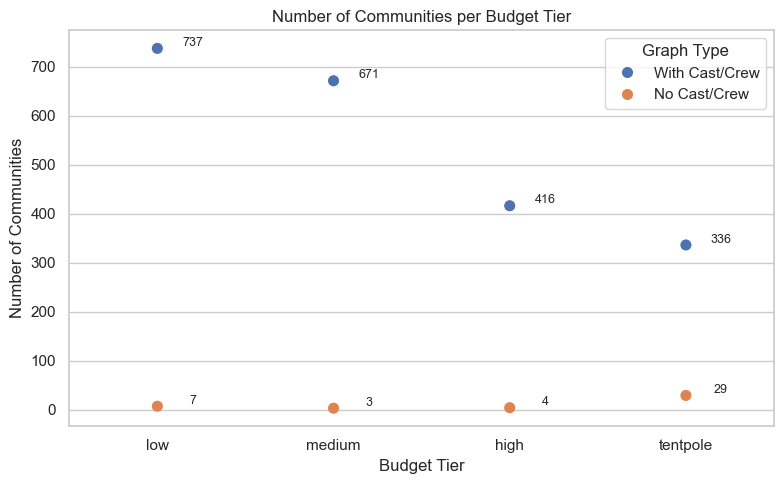

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to only full graphs
movies_df_filtered = movies_df[movies_df["graph_type"].isin(["With Cast/Crew", "No Cast/Crew"])]

# Count communities per graph_type and budget_tier
comm_counts = (
    movies_df_filtered
    .groupby(["graph_type", "budget_tier"])["communityId"]
    .nunique()
    .reset_index()
    .rename(columns={"communityId": "num_communities"})
)

# Set order
graph_order = ["With Cast/Crew", "No Cast/Crew"]
tier_order = ["low", "medium", "high", "tentpole"]

# Plot with safer settings
plt.figure(figsize=(8, 5))
sns.swarmplot(
    data=comm_counts,
    x="budget_tier",
    y="num_communities",
    hue="graph_type",
    hue_order=graph_order,
    order=tier_order,
    size=8
)

# Annotate each point
for i, row in comm_counts.iterrows():
    x_pos = tier_order.index(row["budget_tier"])
    # Shift x slightly based on graph_type
    offset = -0.2 if row["graph_type"] == "with cast/crew" else 0.2
    plt.text(
        x_pos + offset,
        row["num_communities"] + 5,
        f"{int(row['num_communities'])}",
        ha="center",
        fontsize=9
    )

plt.title("Number of Communities per Budget Tier")
plt.ylabel("Number of Communities")
plt.xlabel("Budget Tier")
plt.legend(title="Graph Type", loc="upper right")
plt.tight_layout()
plt.show()


In [98]:
movies_df[movies_df["graph_type"].isin(["With Cast/Crew", "No Cast/Crew"])].copy()

,from_title,communityId,budget_tier,graph_type,Unnamed: 0,from_tconst,from_label,from_year,from_runtimeMinutes,from_averageRating,from_numVotes,from_budget,from_revenue,relationship,to_label,to_name,to_id,to_gender,to_popularity,to_adult,genres,subgenres,from_year_adj,from_budget_adj,from_revenue_adj,from_budget_category,profit,profit_percent_gain,m.betweenness_m2m,m.degree,m.community_id,m.community_size,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Music,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War,genre_Western,subgenre_action-epic,subgenre_alien-invasion-sci-fi,subgenre_alien-invasion-sci-fi-Copy1,subgenre_american-football-sport,subgenre_aquatic-sport,subgenre_artificial-intelligence-sci-fi,subgenre_b-action,subgenre_b-horror,subgenre_baseball-sport,subgenre_basketball-sport,subgenre_body-horror,subgenre_body-swap-comedy,subgenre_boxing-sport,subgenre_buddy-comedy,subgenre_buddy-cop-comedy,subgenre_bumbling-detective-mystery,subgenre_caper-crime,subgenre_car-action,subgenre_cg-animation,subgenre_classic-musical,subgenre_coming-of-age-drama,subgenre_conspiracy-thriller,subgenre_contemporary-western,subgenre_cop-drama,subgenre_costume-drama,subgenre_cozy-mystery,subgenre_cyber-thriller,subgenre_cyberpunk-sci-fi,subgenre_dark-comedy,subgenre_dark-fantasy,subgenre_dark-romance,subgenre_desert-adventure,subgenre_dinosaur-adventure,subgenre_disaster-action,subgenre_docudrama,subgenre_drug-crime,subgenre_dystopian-sci-fi,subgenre_epic-adventure,subgenre_epic-drama,subgenre_epic-fantasy,subgenre_epic-history,subgenre_epic-romance,subgenre_epic-sci-fi,subgenre_epic-war,subgenre_epic-western,subgenre_erotic-thriller,subgenre_fairy-tale-fantasy,subgenre_farce-comedy,subgenre_feel-good-romance,subgenre_financial-drama,subgenre_folk-horror,subgenre_found-footage-horror,subgenre_gangster-crime,subgenre_giant-monster-sci-fi,subgenre_globetrotting-adventure,subgenre_gun-fu-action,subgenre_hardboiled-mystery,subgenre_heist-crime,subgenre_high-concept-comedy,subgenre_holiday-comedy,subgenre_holiday-family,subgenre_holiday-romance,subgenre_holiday-season,subgenre_jukebox-musical,subgenre_jungle-adventure,subgenre_kung-fu-action,subgenre_legal-drama,subgenre_legal-thriller,subgenre_martial-arts-action,subgenre_medical-drama,subgenre_mockumentary-comedy,subgenre_monster-horror,subgenre_motorsports-sport,subgenre_mountain-adventure,subgenre_one-person-army-action,subgenre_parody-comedy,subgenre_period-drama,subgenre_police-procedural-crime,subgenre_political-drama,subgenre_political-thriller,subgenre_pop-musical,subgenre_prison-drama,subgenre_psychological-drama,subgenre_psychological-thriller,subgenre_quest-adventure,subgenre_quirky-comedy,subgenre_raunchy-comedy,subgenre_road-trip-adventure,subgenre_rock-musical,subgenre_romantic-comedy,subgenre_samurai-action,subgenre_satire-comedy,subgenre_screwball-comedy,subgenre_sea-adventure,subgenre_serial-killer-crime,subgenre_showbiz-drama,subgenre_slapstick-comedy,subgenre_slasher-horror,subgenre_soccer-sport,subgenre_space-sci-fi,subgenre_splatter-horror,subgenre_spy-thriller,subgenre_steampunk-sci-fi,subgenre_steamy-romance,subgenre_stoner-comedy,subgenre_superhero-action,subgenre_supernatural-fantasy,subgenre_supernatural-horror,subgenre_survival-adventure,subgenre_suspense-mystery,subgenre_swashbuckler-adventure,subgenre_sword-and-sandal-action,subgenre_sword-and-sorcery-fantasy,subgenre_teen-adventure,subgenre_teen-comedy,subgenre_teen-drama,subgenre_teen-fantasy,subgenre_teen-horror,subgenre_teen-romance,subgenre_time-travel-sci-fi,subgenre_tragedy-drama,subgenre_tragic-romance,subgenre_true-crime,subgenre_urban-adventure,subgenre_vampire-horror,subgenre_werewolf-horror,subgenre_whodunnit-mystery,subgenre_witch-horror,subgenre_workplace-drama,subgenre_wuxia-action,subgenre_zombie-horror
0,Monkey Man,41946,low,With Cast

In [97]:
movies_df["graph_type"].unique()

array(['With Cast/Crew', 'noppl_train', 'No Cast/Crew'], dtype=object)

In [127]:
# List of target test movie titles
target_titles = [
    "Love Actually",
    "Talladega Nights: The Ballad of Ricky Bobby",
    "Scarface",
    "Erin Brockovich",
    "Man on the Moon",
    "Nope"
]

# Filter df_jaccard to only include the target movies
df_subset = df_jaccard[df_jaccard["from_title"].isin(target_titles)]

# Map graph_type to cleaner labels
df_subset["Graph"] = df_subset["graph_type"].map({
    "train": "With Cast/Crew",
    "noppl_train": "No Cast/Crew"
})

# Group by movie and graph type, calculate mean Jaccard
jaccard_summary = df_subset.groupby(["from_title", "Graph"])["jaccard"].mean().unstack()

# Print the result as a table
print("🎬 Average Jaccard Scores:")
print(jaccard_summary.round(3))


KeyError: 'from_title'